In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors
import pynbody
import os

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def get_metallicity_functions(simulation, age_intermediate=6., age_old=10., inner_radius=0., outer_radius=100., plot_agedistribution=False):
    s = pynbody.load(simulation+'/output/snapdir_127/snapshot_127')
    h = s.halos()

    transform = pynbody.analysis.angmom.faceon(h[0])
    s.physical_units()
    main = h[0]
    
    element = {'H':0, 'He':1, 'C':2, 'N':3, 'O':4, 'Ne':5, 'Mg':6, 'Si':7, 'Fe':8}
    elementnum = {'H':1, 'He':4, 'C':12, 'N':14, 'O':16, 'Ne':20, 'Mg':24, 'Si':28, 'Fe':56}
    #from Asplund et al. (2009) Table 5
    SUNABUNDANCES = {'H':12.0, 'He':10.98, 'C':8.47, 'N':7.87, 'O':8.73, 'Ne':7.97, 'Mg':7.64, 'Si':7.55, 'Fe':7.54}
    for iel,val in enumerate(element):
        s.s[val+'/H'] = np.log10( s.s['GFM_Metals'][:, element[val]] / s.s['GFM_Metals'][:, element['H']] / elementnum[val] )
        s.s[val+'/H'] -= (SUNABUNDANCES[val] - SUNABUNDANCES['H'])

    mask_clusters_initial = (main.s['InitialNumberOfClusters'] > 0 ) * (main.s['r'].in_units('kpc')>inner_radius) * (main.s['r'].in_units('kpc')<=outer_radius)
    mask_age_intermediate = (main.s['age'].in_units('Gyr') > age_intermediate)
    mask_age_old = (main.s['age'].in_units('Gyr') > age_old)

    nbins = 15
    low_limit = -3
    high_limit = 1
    met_array = np.linspace(low_limit, high_limit, nbins + 1)
    met_offset = - 0.4
    
    intermediate_age_mdf,_ = np.histogram(s.s[mask_clusters_initial*mask_age_old]['Fe/H'] + met_offset,
                                            weights=s.s[mask_clusters_initial*mask_age_old]['NumberOfClusters'], bins=met_array, density=True)
    old_age_mdf,_ = np.histogram(s.s[mask_clusters_initial*mask_age_intermediate]['Fe/H'] + met_offset,
                                            weights=s.s[mask_clusters_initial*mask_age_intermediate]['NumberOfClusters'], bins=met_array, density=True)
    
    return [intermediate_age_mdf, old_age_mdf]

In [10]:
path = '/home/pdcg/SimsOutput/'
simulation_list = [directory for directory in os.listdir(path) if 'Au6_lvl4' in directory]
print(simulation_list)

['Au6_lvl4_6c8f']


In [11]:
nbins = 15
low_limit = -3
high_limit = 1
met_array = np.linspace(low_limit, high_limit, nbins + 1)

In [12]:
m31_metallicities = np.genfromtxt('../data/Caldwell_dataonly.txt', usecols=8, delimiter=',')
m31_rgc = np.genfromtxt('../data/Caldwell_dataonly.txt', usecols=12, delimiter=',')
m31_metallicity_function,edges = np.histogram(m31_metallicities, bins=met_array, density=True)
m31_inner_metallicity_function,_ = np.histogram(m31_metallicities[m31_rgc <= 3.], bins=met_array, density=True)
m31_intermediate_metallicity_function,_ = np.histogram(m31_metallicities[(m31_rgc > 3.) * (m31_rgc <= 9.)], bins=met_array, density=True)
m31_outer_metallicity_function,_ = np.histogram(m31_metallicities[(m31_rgc > 9.)], bins=met_array, density=True)

mw_catalogue = np.genfromtxt('../data/Harris_onlyphotometry.txt', usecols=(0,6,12), delimiter=',', skip_header=1)
mw_metallicities = mw_catalogue[:,0]
mw_rgc = mw_catalogue[:,2]
mw_metallicity_function,_ = np.histogram(mw_metallicities, bins=met_array, density=True)
mw_inner_metallicity_function,_ = np.histogram(mw_metallicities[mw_rgc <= 3.], bins=met_array, density=True)
mw_intermediate_metallicity_function,_ = np.histogram(mw_metallicities[(mw_rgc > 3.) * (mw_rgc <= 9.)], bins=met_array, density=True)
mw_outer_metallicity_function,_ = np.histogram(mw_metallicities[(mw_rgc > 9.)], bins=met_array, density=True)

In [13]:
intermediate_mdf = []
old_mdf = []

In [14]:
base_intermediate, base_old = get_metallicity_functions(path+simulation_list[0])

/home/pdcg/.local/lib/python3.10/site-packages/pynbody/snapshot/gadgethdf.py:403: UserWarning: Masses are either stored in the header or have another dataset name; assuming the cosmological factor h**-1
  warnings.warn("Masses are either stored in the header or have another dataset name; assuming the cosmological factor %s" % units.h**-1)
/home/pdcg/.local/lib/python3.10/site-packages/pynbody/array/__init__.py:310: RuntimeWarning: divide by zero encountered in log10
  result = super().__array_ufunc__(ufunc, method, *inputs, **kwargs)
/home/pdcg/.local/lib/python3.10/site-packages/pynbody/array/__init__.py:310: RuntimeWarning: invalid value encountered in log10
  result = super().__array_ufunc__(ufunc, method, *inputs, **kwargs)
/home/pdcg/.local/lib/python3.10/site-packages/pynbody/array/__init__.py:310: RuntimeWarning: invalid value encountered in log
  result = super().__array_ufunc__(ufunc, method, *inputs, **kwargs)


Text(0.5, 1.0, 'Au6_lvl4_6c8f')

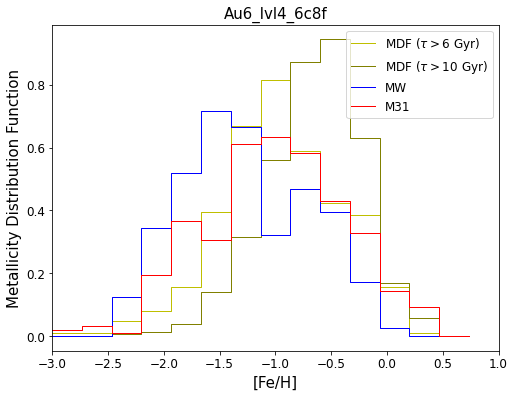

In [15]:
fig, ax = plt.subplots(1,1, figsize=(8,6))

ax.step(met_array[:-1], base_intermediate, where='post',c='y', linewidth = 1, label=r'MDF ($\tau > 6$ Gyr)')
ax.step(met_array[:-1], base_old, where='post',c='olive', linewidth = 1, label=r'MDF ($\tau > 10$ Gyr)')
ax.step(met_array[:-1], mw_metallicity_function, where='post',linewidth=1, c='b', label='MW')
ax.step(met_array[:-1], m31_metallicity_function, where='post',linewidth=1, c='r', label='M31')
ax.set_xlim(low_limit, high_limit)
ax.set_xlabel('[Fe/H]', fontsize=15)
ax.set_ylabel('Metallicity Distribution Function', fontsize=15)
ax.tick_params(labelsize=12)
ax.legend(loc='upper right', fontsize=12)
ax.set_title(simulation_list[0], fontsize=15)

In [ ]:
for sim in simulation_list:
    intermediate, old = get_metallicity_functions(sim)
    intermediate_mdf.append(intermediate)
    old_mdf.append(old)

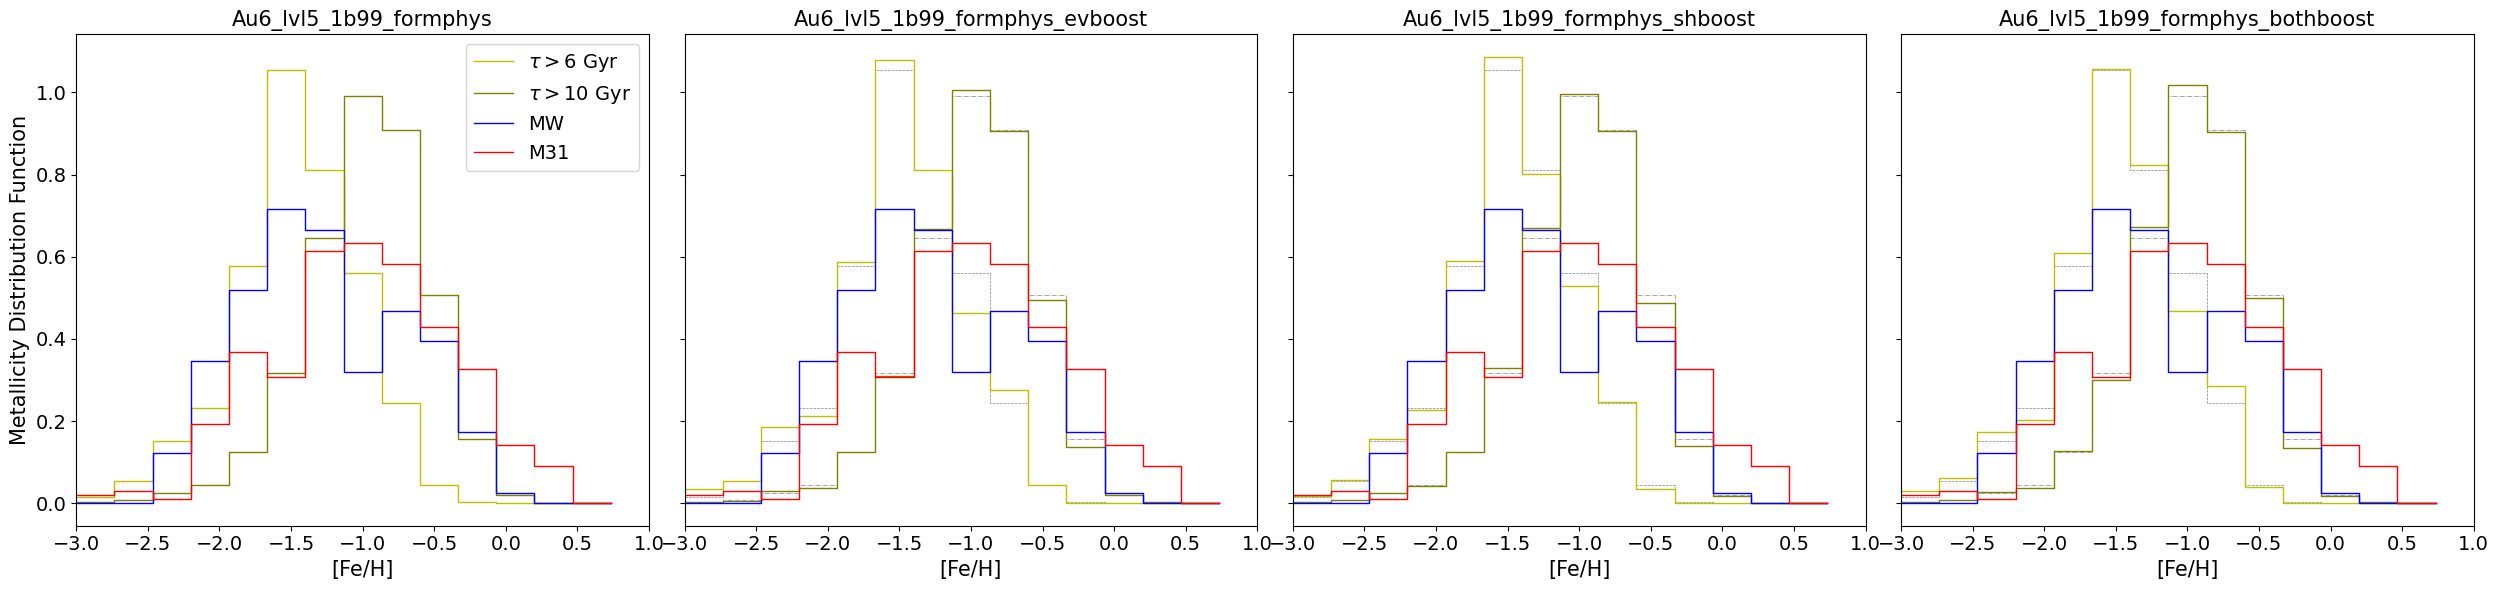

In [35]:
fig, ax = plt.subplots(1, 4, sharey=True, figsize=(25,6))

for i,mf in enumerate(intermediate_mdf):
  ax[i].step(met_array[:-1], base_intermediate, where='post', c='grey', linestyle='--', linewidth=0.5)
  ax[i].step(met_array[:-1], mf, where='post', c='y', linewidth=1, label=r'$\tau > 6$ Gyr')
  
for i,mf in enumerate(old_mdf):
  ax[i].step(met_array[:-1], base_old, where='post', c='grey', linestyle='-.', linewidth=0.5)
  ax[i].step(met_array[:-1], mf, where='post', c='olive', linewidth=1, label=r'$\tau > 10$ Gyr')

for i in range(4):
  ax[i].step(met_array[:-1], mw_metallicity_function, where='post', linewidth=1, c='b', label='MW')
  ax[i].step(met_array[:-1], m31_metallicity_function, where='post', linewidth=1, c='r', label='M31')
  ax[i].set_xlim(low_limit, high_limit)
  ax[i].set_xlabel('[Fe/H]', fontsize=15)
  ax[i].tick_params(labelsize=14)
  ax[i].set_title(simulation_list[i], fontsize=15)

ax[0].set_ylabel('Metallicity Distribution Function', fontsize=15)
ax[0].legend(loc='upper right', fontsize=14)

plt.tight_layout()
plt.savefig('plots/formphys_mdf_compare.pdf')

In [33]:
all_intermediate, all_old = get_metallicity_functions(simulation_list[0], age_intermediate=6., age_old=10.)
inner_intermediate, inner_old = get_metallicity_functions(simulation_list[0], outer_radius=3., age_intermediate=6., age_old=10.)
intermediate_intermediate, intermediate_old = get_metallicity_functions(simulation_list[0], inner_radius=9., age_intermediate=6., age_old=10.)
outer_intermediate, outer_old = get_metallicity_functions(simulation_list[0], inner_radius=9., age_intermediate=6., age_old=10.)

/users/aripcont/.local/lib/python3.10/site-packages/pynbody/snapshot/gadgethdf.py:403: UserWarning: Masses are either stored in the header or have another dataset name; assuming the cosmological factor h**-1
  warnings.warn("Masses are either stored in the header or have another dataset name; assuming the cosmological factor %s" % units.h**-1)
/users/aripcont/.local/lib/python3.10/site-packages/pynbody/array/__init__.py:310: RuntimeWarning: divide by zero encountered in log10
  result = super().__array_ufunc__(ufunc, method, *inputs, **kwargs)
/users/aripcont/.local/lib/python3.10/site-packages/pynbody/array/__init__.py:310: RuntimeWarning: invalid value encountered in log10
  result = super().__array_ufunc__(ufunc, method, *inputs, **kwargs)
/users/aripcont/.local/lib/python3.10/site-packages/pynbody/array/__init__.py:310: RuntimeWarning: invalid value encountered in log
  result = super().__array_ufunc__(ufunc, method, *inputs, **kwargs)


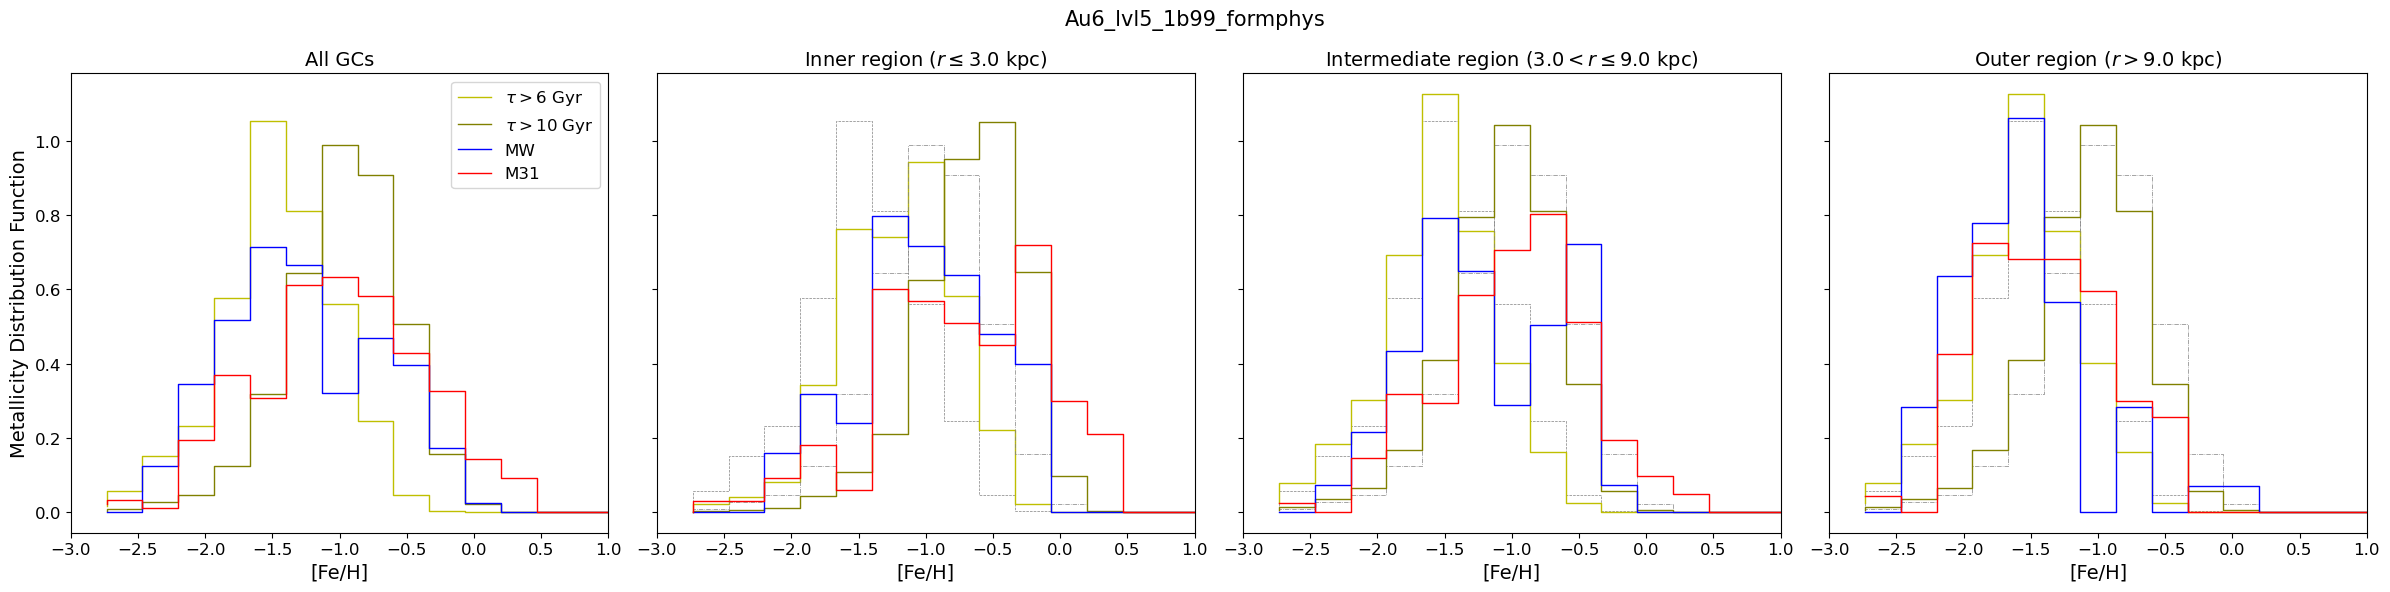

In [34]:
fig, ax = plt.subplots(1,4, figsize=(24,6), sharey=True)

ax[0].step(met_array[1:], all_intermediate, where='pre',c='y', linewidth = 1, label=r'$\tau > 6$ Gyr')
ax[0].step(met_array[1:], all_old, where='pre',c='olive', linewidth = 1, label=r'$\tau > 10$ Gyr')
ax[0].step(met_array[1:], mw_metallicity_function, where='pre',linewidth=1, c='b', label='MW')
ax[0].step(met_array[1:], m31_metallicity_function, where='pre',linewidth=1, c='r', label='M31')
ax[0].set_title('All GCs', fontsize=14)
ax[0].set_xlim(low_limit, high_limit)
ax[0].set_xlabel('[Fe/H]', fontsize=14)
ax[0].tick_params(labelsize=12)

ax[1].step(met_array[1:], all_intermediate, where='pre',c='gray', linestyle='dashed', linewidth = 0.5, label=r'$\tau > 6$ Gyr')
ax[1].step(met_array[1:], inner_intermediate, where='pre',c='y', linewidth = 1, label=r'$\tau > 6$ Gyr')
ax[1].step(met_array[1:], all_old, where='pre',c='gray', linestyle='dashdot', linewidth = 0.5, label=r'$\tau > 10$ Gyr')
ax[1].step(met_array[1:], inner_old, where='pre',c='olive', linewidth = 1, label=r'$\tau > 10$ Gyr')
ax[1].step(met_array[1:], mw_inner_metallicity_function, where='pre',linewidth=1, c='b', label='MW')
ax[1].step(met_array[1:], m31_inner_metallicity_function, where='pre',linewidth=1, c='r', label='M31')
ax[1].set_title(r'Inner region ($r \leq 3.0$ kpc)', fontsize=14)
ax[1].set_xlim(low_limit, high_limit)
ax[1].set_xlabel('[Fe/H]', fontsize=14)
ax[1].tick_params(labelsize=12)

ax[2].step(met_array[1:], all_intermediate, where='pre',c='gray', linestyle='dashed', linewidth = 0.5, label=r'$\tau > 6$ Gyr')
ax[2].step(met_array[1:], intermediate_intermediate, where='pre',c='y', linewidth = 1, label=r'$\tau > 6$ Gyr')
ax[2].step(met_array[1:], all_old, where='pre',c='gray', linestyle='dashdot', linewidth = 0.5, label=r'$\tau > 10$ Gyr')
ax[2].step(met_array[1:], intermediate_old, where='pre',c='olive', linewidth = 1, label=r'$\tau > 10$ Gyr')
ax[2].step(met_array[1:], mw_intermediate_metallicity_function, where='pre',linewidth=1, c='b', label='MW')
ax[2].step(met_array[1:], m31_intermediate_metallicity_function, where='pre',linewidth=1, c='r', label='M31')
ax[2].set_title(r'Intermediate region ($3.0 < r \leq 9.0$ kpc)', fontsize=14)
ax[2].set_xlim(low_limit, high_limit)
ax[2].set_xlabel('[Fe/H]', fontsize=14)
ax[2].tick_params(labelsize=12)

ax[3].step(met_array[1:], all_intermediate, where='pre',c='gray', linestyle='dashed', linewidth = 0.5, label=r'$\tau > 6$ Gyr')
ax[3].step(met_array[1:], outer_intermediate, where='pre',c='y', linewidth = 1, label=r'$\tau > 6$ Gyr')
ax[3].step(met_array[1:], all_old, where='pre',c='gray', linestyle='dashdot', linewidth =0.5, label=r'$\tau > 10$ Gyr')
ax[3].step(met_array[1:], outer_old, where='pre',c='olive', linewidth = 1, label=r'$\tau > 10$ Gyr')
ax[3].step(met_array[1:], mw_outer_metallicity_function, where='pre',linewidth=1, c='b', label='MW')
ax[3].step(met_array[1:], m31_outer_metallicity_function, where='pre',linewidth=1, c='r', label='M31')
ax[3].set_title(r'Outer region ($r > 9.0$ kpc)', fontsize=14)
ax[3].set_xlim(low_limit, high_limit)
ax[3].set_xlabel('[Fe/H]', fontsize=14)
ax[3].tick_params(labelsize=12)


ax[0].set_ylabel('Metallicity Distribution Function', fontsize=14)
ax[0].legend(loc='upper right', fontsize=12)
plt.suptitle(simulation_list[0], fontsize=15)
plt.tight_layout()
plt.savefig('plots/formphys_mdf_radialbins.pdf')